In [1]:
import tensorflow.compat.v1 as tf
import keras as K
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
from keras.callbacks import ModelCheckpoint
from keras import backend
from numba import cuda
from keras.models import load_model

In [2]:
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
train_path = "./flower_tpu/flowers_google/"
labels_path = "./datasets_527293_966816_flowers_label.csv"
ids_path = "./datasets_527293_966816_flowers_idx.csv"

In [4]:
def PrepareAnnotation(ids_path, labels_path, train_path):
    
    ids = pd.read_csv(ids_path)
    labels  = pd.read_csv(labels_path)
    
    annotation_dict = {}

    for i in range(len(ids['id'])):
        image_id = ids['id'][i]
        image_lable = ids['flower_cls'][i]
        annotation_dict[image_id] = image_lable
    
    label_dict = {}
    num_classes = 0

    for i in range(len(labels['flower_class'])):
        label_dict[labels['flower_class'][i]] = labels['label'][i]
        num_classes+=1
        
    for key, value in annotation_dict.items():
        annotation_dict[key] = label_dict[value]
    
    image_pathes = []
    targets = []
    
    for key, value in annotation_dict.items():
        
        image_name = str(key) + ".jpeg"
        image_path = os.path.join(train_path, image_name)
        image_pathes.append(image_path)
        targets.append(value)
    
    return image_pathes, targets, num_classes

In [5]:
image_pathes, targets, num_classes = PrepareAnnotation(ids_path, labels_path, train_path)

In [6]:
val_ratio = 0.2
x_train, x_val, y_train, y_val = train_test_split(image_pathes, targets, test_size=val_ratio, random_state=42, shuffle = True)
print("num_train = ", len(x_train))
print("num_valid = ", len(x_val))

num_train =  13172
num_valid =  3293


In [7]:
def SelectSamplesForEachClass(x_train, y_train, num_examples):
    class_image_path = {}
    
    for i in range(len(y_train)):
        if (y_train[i] in class_image_path):
            if len(class_image_path[y_train[i]]) < num_examples:
                   class_image_path[y_train[i]].append(x_train[i])
        
        else:
            class_image_path[y_train[i]] = [x_train[i]]        
    
    return class_image_path

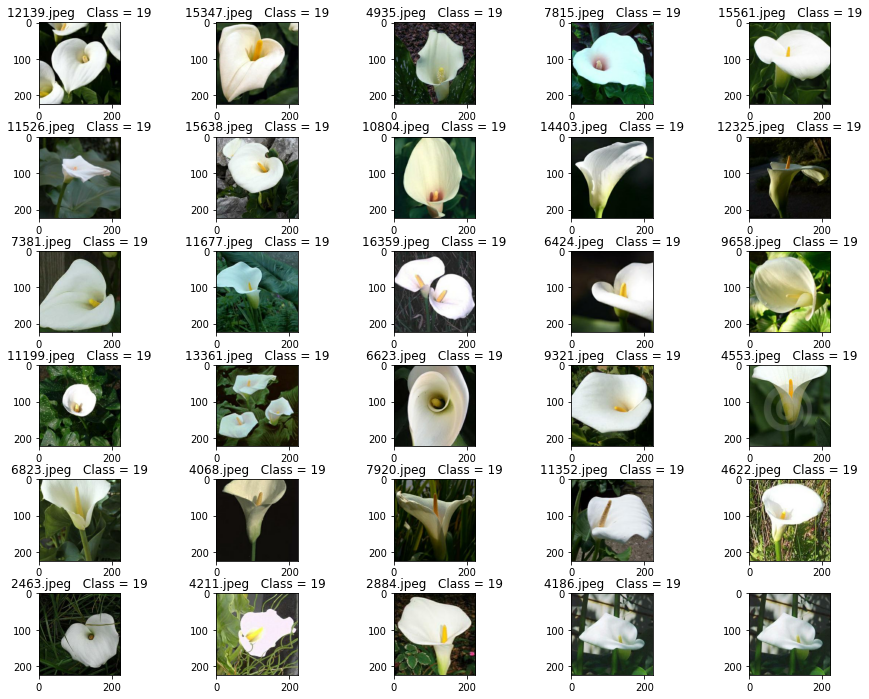

In [8]:
class_label = 19 # Try other Classes.
num_examples_to_show = 30

class_image_path_ = SelectSamplesForEachClass(x_train, y_train, num_examples_to_show)

images = class_image_path_[class_label]

fig, ax = plt.subplots(6,5, figsize=(15,12))
fig.subplots_adjust(hspace = 0.4, wspace = 0.4)

ax = ax.ravel()
i = 0
for image in images:
    img = cv2.imread(image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax[i].imshow(img)
    
    plt.imshow(img)
    
    title_txt = image.split("/")[-1] + "   " + "Class = " + str(class_label)
    ax[i].set_title(title_txt)
    i+=1

In [40]:
def Generator(X, Y, batch_size):
    
    while True:
        indexes = np.random.choice(len(X), batch_size)
        x = []
        y = []
    
        for index in indexes:
            x.append(X[index]) 
            y.append(Y[index])
        
        x_batch = []
        
        y_batch = K.utils.to_categorical(y, num_classes= num_classes)
        
        for i in range(len(x)):
            image = cv2.imread(x[i])
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = K.applications.resnet50.preprocess_input(image)
            x_batch.append(image)
        
        x_batch = np.array(x_batch)
        
        yield x_batch, y_batch

In [41]:
def ResNet50Model():
    model = K.applications.ResNet50(include_top=False, weights="imagenet", input_shape =(224, 224, 3))
    
    new_output = K.layers.GlobalAveragePooling2D()(model.output)
    new_output = K.layers.Dense(num_classes, activation = 'softmax')(new_output)
    
    model = K.engine.training.Model(model.inputs, new_output)
    
    return model

In [42]:
model = ResNet50Model()

In [43]:
print("num_layers = ", len(model.layers))

num_layers =  177


In [44]:
# Freez first 168 Layers Except the Batch Normalization ones.
num_feerezed_layer = 168

for layer in model.layers:
    layer.trainable = True
    
    if isinstance(layer, K.layers.BatchNormalization):
        # Set Batch Norm momentun to 0.9 to faster adapt to the new DataSet.
        layer.momentum = 0.9

for layer in model.layers[:num_feerezed_layer]:
    
    if not isinstance(layer, K.layers.BatchNormalization):
        layer.trainable = False
        
# Check if the trainable layers are set Correctly
for layer in model.layers:
    print(layer.name, " ", "trainable = ", layer.trainable)

input_4   trainable =  False
conv1_pad   trainable =  False
conv1_conv   trainable =  False
conv1_bn   trainable =  True
conv1_relu   trainable =  False
pool1_pad   trainable =  False
pool1_pool   trainable =  False
conv2_block1_1_conv   trainable =  False
conv2_block1_1_bn   trainable =  True
conv2_block1_1_relu   trainable =  False
conv2_block1_2_conv   trainable =  False
conv2_block1_2_bn   trainable =  True
conv2_block1_2_relu   trainable =  False
conv2_block1_0_conv   trainable =  False
conv2_block1_3_conv   trainable =  False
conv2_block1_0_bn   trainable =  True
conv2_block1_3_bn   trainable =  True
conv2_block1_add   trainable =  False
conv2_block1_out   trainable =  False
conv2_block2_1_conv   trainable =  False
conv2_block2_1_bn   trainable =  True
conv2_block2_1_relu   trainable =  False
conv2_block2_2_conv   trainable =  False
conv2_block2_2_bn   trainable =  True
conv2_block2_2_relu   trainable =  False
conv2_block2_3_conv   trainable =  False
conv2_block2_3_bn   trainable

In [45]:
model.summary()

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
_______________________________________________________________________________________

In [46]:
checkpoint = ModelCheckpoint('Best_Model.h5', verbose=1, monitor='val_accuracy',save_best_only=True, mode='max')

In [47]:
model.compile(loss='categorical_crossentropy', optimizer = K.optimizers.Adamax(lr=0.01), metrics=['accuracy'])

In [50]:
batch_size = 32
model.fit(Generator(x_train, y_train, batch_size), 
          steps_per_epoch=len(x_train)//batch_size,
          epochs= 2,
          validation_data=Generator(x_val, y_val, batch_size),
          validation_steps=len(x_val) // batch_size,
          callbacks=[checkpoint])

Epoch 1/2
411/411 [==============================] - ETA: 0s - loss: 0.0359 - accuracy: 0.9902
Epoch 00001: val_accuracy improved from 0.87745 to 0.89093, saving model to Best_Model.h5
411/411 [==============================] - 397s 967ms/step - loss: 0.0359 - accuracy: 0.9902 - val_loss: 0.5608 - val_accuracy: 0.8909
Epoch 2/2
411/411 [==============================] - ETA: 0s - loss: 0.0372 - accuracy: 0.9887
Epoch 00002: val_accuracy improved from 0.89093 to 0.89124, saving model to Best_Model.h5
411/411 [==============================] - 433s 1s/step - loss: 0.0372 - accuracy: 0.9887 - val_loss: 0.5339 - val_accuracy: 0.8912


In [55]:
final_model = load_model("Best_Model.h5")
val_accuracy = final_model.evaluate_generator(Generator(x_val, y_val, batch_size), len(x_val) // batch_size)[1]

0.8881739974021912


In [56]:
print("Validation Accuracy = ", val_accuracy)

Validation Accuracy =  0.8881739974021912


In [57]:
def VisualizePrediction(path, gt_label):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    plt.imshow(image)
    
    image = K.applications.resnet50.preprocess_input(image)
    image = np.expand_dims(image, axis = 0)
    
    probabilities = model.predict(image)
    predicted_label = np.argmax(probabilities, axis = 1)
    
    title_txt = "Prediction = " + str(predicted_label[0]) + "     " + "gt = " + str(gt_label)
    plt.title(title_txt)

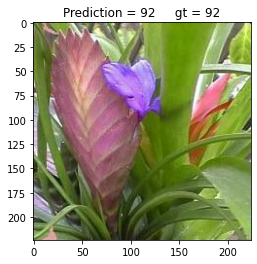

In [58]:
sample = 500 # Try different Samples
image_path = x_val[sample]
gt_label = y_val[sample]

# Make Predictions on Training Data set.
# image_path = x_train[sample]
# gt_label = y_train[sample]

VisualizePrediction(image_path, gt_label)